# Project: Web Traffic Forecasting

Ruoxin Jiang and Bingyan Hu

## Overview

The goal of our project is to **forecast web traffic for Wikipedia pages**. Forecasting time series is a challenging task since we need to combine trend, seasonality, and other factors intelligently in modeling. Moreover, as we observe during the project, historical data itself alone is often insufficient to capture full uncertainty in future events. 


We obtained real time series data from [a recent Kaggle competition](https://www.kaggle.com/c/web-traffic-time-series-forecasting). The dataset contains web traffic time series for 145k Wikipedia pages. Each time series represents daily views of a Wikipedia page from **07/01/2015** to **09/10/2017**. 


We first designed and implemented an additive model of linear growth along with yearly and weekly seasonality to predict single time series. The basic model was inspired by the  [Facebook Prophet model](https://facebookincubator.github.io/prophet/static/prophet_paper_20170113.pdf). While analyzing and criticising the forecasting results, we raised the following question: **Can we improve our forecasting results by inferring several time series together which have related content or fall in the same category? **

In our experiments, we used time series of 10 Wikipedia pages, all of them related to the same topic. We then created two  mixed time series model and iterated through the Box's loop for criticism and model improvement.



In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import edward as ed
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
import itertools

from models import *
from utils import *
from pipeline import *
from prediction import *
from visualize import *
from cross_validation import cross_validation

%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (24, 12)
matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['xtick.labelsize'] = 20
matplotlib.rcParams['ytick.labelsize'] = 20
matplotlib.rcParams['xtick.color'] = 'k'
matplotlib.rcParams['ytick.color'] = 'k'
ed.set_seed(42)

## Data

We experimented on time series of 10 Wikipedia pages related to the topic of NFL. We obtained these time series by scraping all linked Wiki pages from [NFL wiki](https://en.wikipedia.org/wiki/National_Football_League) and finding their corresponding time series in the dataset. 

We further splitted each time series on date **07/10/2017**. The part of time series until the split point (741 days in total) forms the historical data to train our models on, and we evaluate our models using the time series of the next 62 days. 


Before the experiments, we log-transformed and scaled the views data, a common practice in predicting time series. Log transformation generally works well with non-negative data such as web traffic. Moreover, we transformed the time indices to real values to make modeling more convenience. The transformed time indices in historical data range from 0 to 1, and increase from 1 in the future data.  


In [2]:
# Load data into DataFrame
FPATH = "./data/nfl_teams.csv"

timeseries = get_timeseries(FPATH)
pages = timeseries.keys()
ts_dfs = []
for p in pages:
    print("Preparing timeseries %s" % p)
    df = setup_dataframe(timeseries[p])
    ts_dfs.append(df)

Loading timeseries:
Preparing timeseries Denver_Broncos_en.wikipedia.org_mobile-web_all-agents
Preparing timeseries Green_Bay_Packers_en.wikipedia.org_mobile-web_all-agents
Preparing timeseries Carolina_Panthers_en.wikipedia.org_mobile-web_all-agents
Preparing timeseries Dallas_Cowboys_en.wikipedia.org_mobile-web_all-agents
Preparing timeseries Los_Angeles_Rams_en.wikipedia.org_mobile-web_all-agents
Preparing timeseries National_Football_League_en.wikipedia.org_desktop_all-agents
Preparing timeseries New_England_Patriots_en.wikipedia.org_mobile-web_all-agents
Preparing timeseries Pittsburgh_Steelers_en.wikipedia.org_mobile-web_all-agents
Preparing timeseries Atlanta_Falcons_en.wikipedia.org_mobile-web_all-agents
Preparing timeseries Arizona_Cardinals_en.wikipedia.org_mobile-web_all-agents


In [3]:
%%capture
# Split history (train) and future (test)
sdate = pd.datetime(2017, 7, 10)
ts_data = []
for df in ts_dfs: 
    history, future, y_scale = split_train_test(df, sdate)
    ts_data.append({
        "history": history, "future": future, "y_scale": y_scale
    })
    
print("Extracting features")
# same feature matrix for all test series  
train_data = extract_features(ts_data[0]["history"])
test_data = extract_features(ts_data[0]["future"], changepoints_t=train_data["t_change"])
assert(all(train_data["X"].columns ==  test_data["X"].columns))
assert(all(train_data["t_change"] == test_data["t_change"]))

,ds,views,y,t,y_scaled
0,2015-07-01,452,6.113682,0.000000,0.490773
1,2015-07-02,437,6.079933,0.001351,0.488064
2,2015-07-03,465,6.142037,0.002703,0.493049
3,2015-07-04,454,6.118097,0.004054,0.491128
4,2015-07-05,483,6.180017,0.005405,0.496098


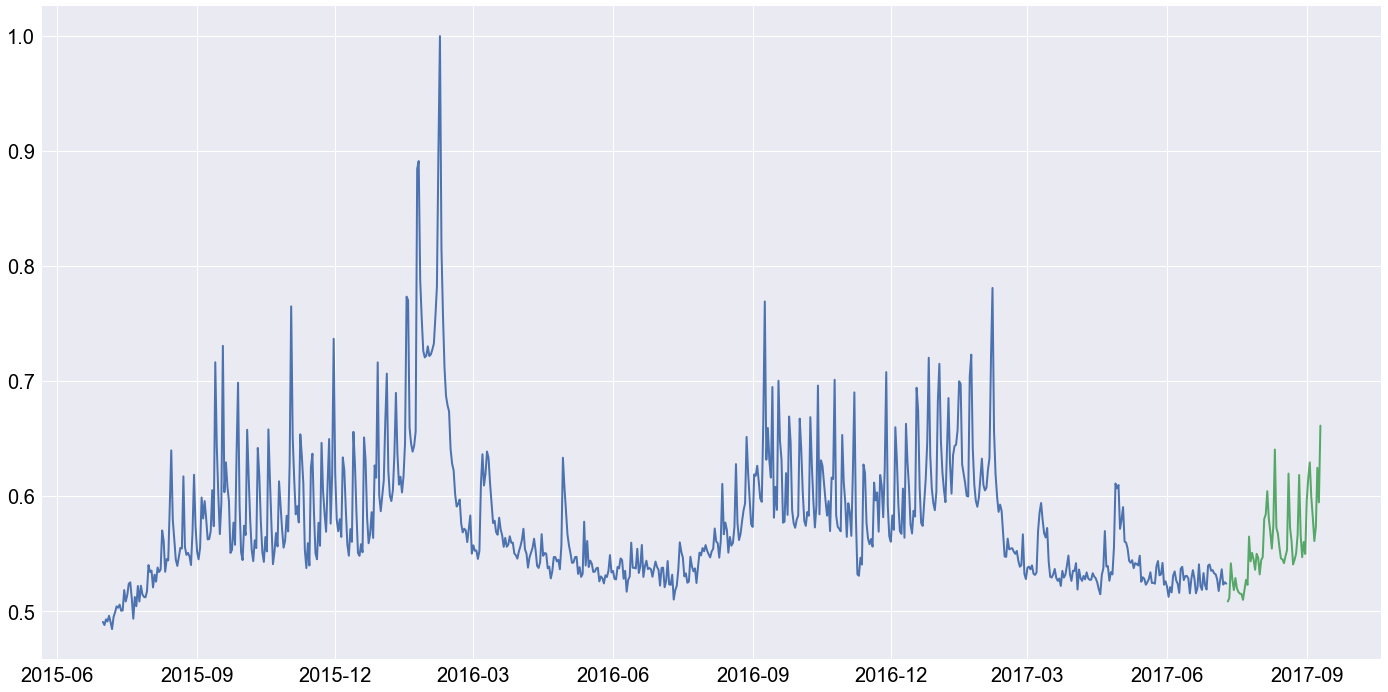

In [4]:
ts_example = ts_data[0]
plt.plot(ts_example["history"]["ds"], ts_example["history"]["y_scaled"])
plt.plot(ts_example["future"]["ds"], ts_example["future"]["y_scaled"])
ts_example["history"].head()

## Round 0:  

## Model 0: Addictive Regression model

We start by implementing an addictive regression model similar to [Facebook Prophet](https://peerj.com/preprints/3190/) to predict single time series.

The model combines linear trend, and non-linear seasonality (yearly and weekly) and holiday components applied to regressor $t$, i.e. the transformed time index.

$$y(t) = g(t) + s(t) + h(t) + \epsilon_{t}  $$

* **Trend $g(t)$** 

  $$g(t) = (k + \mathbf{a}(t)^{T} \boldsymbol{\delta})t + (m + \mathbf{a}(t)^{T} \boldsymbol{\gamma})$$
  
  * $k$ is the linear growth rate (slope)
  * $m$ is the linear growth offset (intercept)
  * $S$ are changepoints explicitly defined to allow trend changes at times $s_{j， j \in {1,2,...,S}}$
  * $\mathbf{a}(t) \in \{0,1\}^{S}$ are changepoint indicators: $a_j(t) = \mathcal{1}\{t \ge s_j\}$ 

  * $\delta_{j}$ is the change in rate at time $s_{j}$. We uses prior $Laplace(0,\tau)$ for $\delta$ 
  * $\gamma_{j}$ is set to $-s_{j}\delta_{j}$ to make the function continuous</br>


- **Seasonality $s(t)$ **

   We approximate the periodic seasonality in time series with Fourier series.
   
  $$s(t) = \sum_{n=1}^{N}(a_{n}cos(\frac{2\pi nt}{P}) + b_{n}sin(\frac{2\pi nt}{P} )) = X(t)  \boldsymbol{\beta}$$
    - $\boldsymbol{\beta} = [a_{1}, b_{1} , ... , a_{N}, b_{N}]^{T}$ represents the smooth element of the Fourier series. We set its prior as $Normal(0,\sigma^{2})$
    
    - $P$ is the regular period we expect the time series to have. Thus P = 365.25 for yearly seasonality and 7 for weekly seasonality.
     
    - $N = 10 $ for yearly, and $3$ for weekly.


- **Holiday/Events $h(t)$ ** 
  
  Holiday can help capture predictable shocks to the timeseries without periodic effects. 
  The model allows input of a list of holidays $D_{1}, ... D_{L}$ and learns its changes to use in forecasting.
  
  $$h(t) = Z(t) \boldsymbol{\kappa}$$
    - $Z(t) = [\boldsymbol{1}(t\in D_{1}) , ... , \boldsymbol{1}(t\in D_{L})]$
    - $\boldsymbol{\kappa}$ is the changes on the holidays. We uses a prior $\sim Normal(0, \nu^2)$
    

To confirm with the model, we decompose the historical and future time series data into the following components: 

* **t ** is the tranformed time index 
* **X ** is the matrix of seasonality vectors $X(t)$
* **A ** is a matrix of changepoint indicator $a(t)$
* **t_change** are the change points in time
* **sigmas ** is a tunable parameter to control the amount of regularization on seasonality, in order to prevent overfitting
* **tau** is also a tunable parameter to control regularization on changepoint adjustment.


The latent varables of the model are $k,m,\boldsymbol{\delta},\tau,\boldsymbol{\beta}$ and $\sigma_{obs}$, where $k$ and $m$ are slope and intercept of the linear trend, $\boldsymbol{\delta}$ changepoint rate adjustments, $\boldsymbol{\beta}$ smoothers for seasonality, and $\sigma_{obs}$ the noise.

In [5]:
N_TS = len(ts_data)
S = len(train_data["t_change"])
K = train_data["X"].shape[1]

t = tf.placeholder(tf.float32, shape=None, name="t")              # time index
A = tf.placeholder(tf.float32, shape=(None, S), name="A")         # changepoint indicators
t_change = tf.placeholder(tf.float32, shape=(S), name="t_change") # changepoints_t
X = tf.placeholder(tf.float32, shape=(None, K), name="X")         # season vectors
sigmas = tf.placeholder(tf.float32, shape=(K,), name="sigmas")    # scale on seasonality prior
tau = tf.placeholder(tf.float32, shape=(), name="tau")

k = Normal(loc=tf.zeros(1), scale=5.0*tf.ones(1))     # initial slope
m = Normal(loc=tf.zeros(1), scale=5.0*tf.ones(1))     # initial intercept

sigma_obs = Normal(loc=tf.zeros(1), scale=0.5*tf.ones(1))   # noise
delta = Laplace(loc=tf.zeros(S), scale=tau*tf.ones(S))    # changepoint rate adjustment
gamma = tf.multiply(-t_change, delta)
beta = Normal(loc=tf.zeros(K), scale=sigmas*tf.ones(K))      # seasonal
trend_loc = (k + ed.dot(A, delta)) * t + \
            (m + ed.dot(A, gamma))
seas_loc = ed.dot(X, beta)
y = Normal(loc = trend_loc + seas_loc, scale = sigma_obs)

### Inference: HMC

Given the historical data, we can infer the posterior values of $k,m,\boldsymbol{\delta},\tau,\boldsymbol{\beta}$ and $\sigma$ using Hamiltonian Monte Carlo implemented in `ed.HMC`. We sample for 5000 iterations, with step_size $= 0.0005$, n_steps $= 2$.

We initialize the $\sigma_{obs}$, $\beta$ and $\delta$ to zeros. For $k, m$, we initialize them with the global slope and intercept of the historical data:

$$ k_{init} = \dfrac{y[t_{start}] - y[t_{end}]}{t_{end} - t_{start}}, \;\;\;\; m_{init} = y[t_{start}] - k_{init} * t_{start} $$


In [6]:
ITR = 5000
kinit, minit = init_km(ts_example["history"])
print("[+] Initial slope / intercept: %f, %f" % (kinit, minit))
qk = Empirical(params=tf.Variable(kinit * tf.ones([ITR, 1])))
qm = Empirical(params=tf.Variable(minit * tf.ones([ITR, 1])))
qsigma_obs = Empirical(params=tf.Variable(tf.ones([ITR, 1])))
qbeta = Empirical(params=tf.Variable(tf.zeros([ITR, K])))
qdelta = Empirical(params=tf.Variable(tf.zeros([ITR, S])))

[+] Initial slope / intercept: 0.033256, 0.490773


In [7]:
posts_dict = {
    k: qk, m: qm, sigma_obs: qsigma_obs,
    beta: qbeta, delta: qdelta}

data_dict = {
    y: ts_data[0]["history"]["y_scaled"].as_matrix(),
    t: train_data["t"],
    X: train_data["X"],
    sigmas: train_data["sigmas"],
    A: train_data["A"],
    t_change: train_data["t_change"],
    tau: 0.05,
}

inference = ed.HMC(posts_dict, data=data_dict)
STEP_SIZE = 5e-4
N_STEPS = 2
inference.run(step_size=STEP_SIZE, n_steps=N_STEPS)

5000/5000 [100%] ██████████████████████████████ Elapsed: 9s | Acceptance Rate: 0.955


### Prediction

Since Edward has not implemented warm-up in MCMC, we manually burn in the posterior samples to use for prediction. We select at every 5 values in the latter half of the iterations, and get 250 posterior samples for each latent variable.

  
Reference:
https://github.com/blei-lab/edward/blob/e8e94174c4b8f4ef7fedde90e47c0a61de75ade4/edward/inferences/monte_carlo.py

In [8]:
nburn = int(ITR / 2)
stride = 5
sess = ed.get_session()
post_params = {
    "k": qk.params.eval()[nburn:ITR:stride],
    "m": qm.params.eval()[nburn:ITR:stride],
    "beta": qbeta.params.eval()[nburn:ITR:stride],
    "delta": qdelta.params.eval()[nburn:ITR:stride]
}

In [9]:
from prediction import *

pred_example = make_future_dataframe(ts_example["history"], ts_example["future"].shape[0])
pred_example = predict_fixed(pred_example, post_params, test_data)
pred_example_interval = predict_uncertainty(pred_example, post_params, test_data)
pred_example.head()

,ds,t,trend,seasonal,seasonal_lower,seasonal_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,y
0,2017-07-11,1.001351,0.580410,-0.056131,-0.063876,-0.048385,-0.002971,-0.006525,0.001159,-0.053160,-0.059956,-0.045995,0.524279
1,2017-07-12,1.002703,0.580496,-0.068783,-0.077001,-0.060588,-0.015302,-0.019159,-0.011285,-0.053481,-0.060387,-0.046511,0.511713
2,2017-07-13,1.004054,0.580582,-0.069114,-0.077026,-0.061193,-0.015432,-0.019273,-0.011581,-0.053681,-0.060572,-0.046656,0.511468
3,2017-07-14,1.005405,0.580668,-0.056230,-0.064145,-0.047931,-0.002497,-0.006149,0.001220,-0.053733,-0.060747,-0.046590,0.524438
4,2017-07-15,1.006757,0.580754,-0.063163,-0.072194,-0.054943,-0.009550,-0.014057,-0.005421,-0.053613,-0.060649,-0.046474,0.517591


,trend_lower,trend_upper,y_lower,y_upper
0,0.575307,0.585395,0.519176,0.529264
1,0.575366,0.585501,0.506583,0.516719
2,0.575414,0.585607,0.506301,0.516494
3,0.575475,0.585713,0.519245,0.529483
4,0.575543,0.585820,0.512380,0.522657


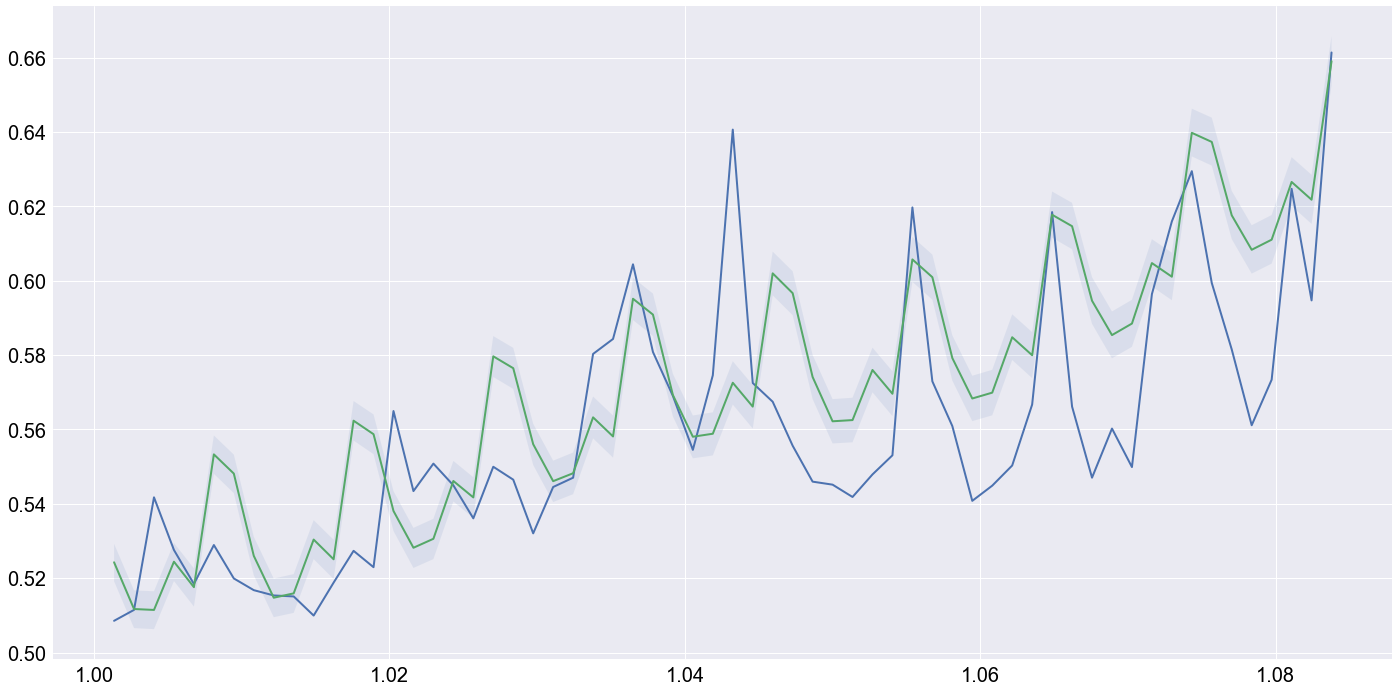

In [10]:
plt.plot(ts_example["future"]["t"], ts_example["future"]["y_scaled"])
plt.plot(pred_example["t"], pred_example["y"])
plt.fill_between(pred_example["t"], pred_example_interval["y_lower"], pred_example_interval["y_upper"], alpha=0.1)
pred_example_interval.head()

### Criticism

#### Pointwise evaluation

We use three different methods to evaluate our basic model. We first compare the model's forecasting accuarcy on the future data via three metrics `MAPE`, and `SMAPE` and `MSE`.
`MSE` is the most common metrics for prediction accuarcy; `MAPE` and `SMAPE` work well in our case since they are invariant to scaling. According to our experience, `MAPE` penalizes more on negative errors and `SMAPE` has unstable behavior near zero values, so we look at both of them in criticism. 


In [11]:
y_true = ts_example["future"]["y_scaled"].as_matrix()
metrics_example  = evaluate(y_true, pred_example["y"], prefix="example")
m_pd = pd.DataFrame.from_dict([metrics_example])
m_pd.loc['mean'] = m_pd.mean()
print(m_pd)

      example-MAPE  example-MSE  example-SMAPE
0         3.612184     0.000633       3.554302
mean      3.612184     0.000633       3.554302


In [12]:
# Training 
pred_train_example = pd.DataFrame({"ds": ts_example["history"]["ds"].copy(),
                                  "t": ts_example["history"]["t"].copy()})
pred_train_example.reset_index(inplace=True, drop=True)
pred_train_example = predict_fixed(pred_train_example, post_params, train_data)

#### Visualization

One major benefit of using an additive model is that we can decompose our prediction results into subcomponents and take a closer look at each. Plotting components separately has given us  insights into how our models behave and how we can further improve it.

Below we decompose the prediction results of one time series into trend, yearly seasonality, weekly seasonlity, and the residual i.e., the gap between prediction results and true values. According to the plots, our basic model captures the trend and weekly seasonality quite well but it is unable to pick up local peaks. 

We further check on the residuals. According to the last two plots, the residuals in general are normally distributed with mean at 0, which ensures our choice of the model.

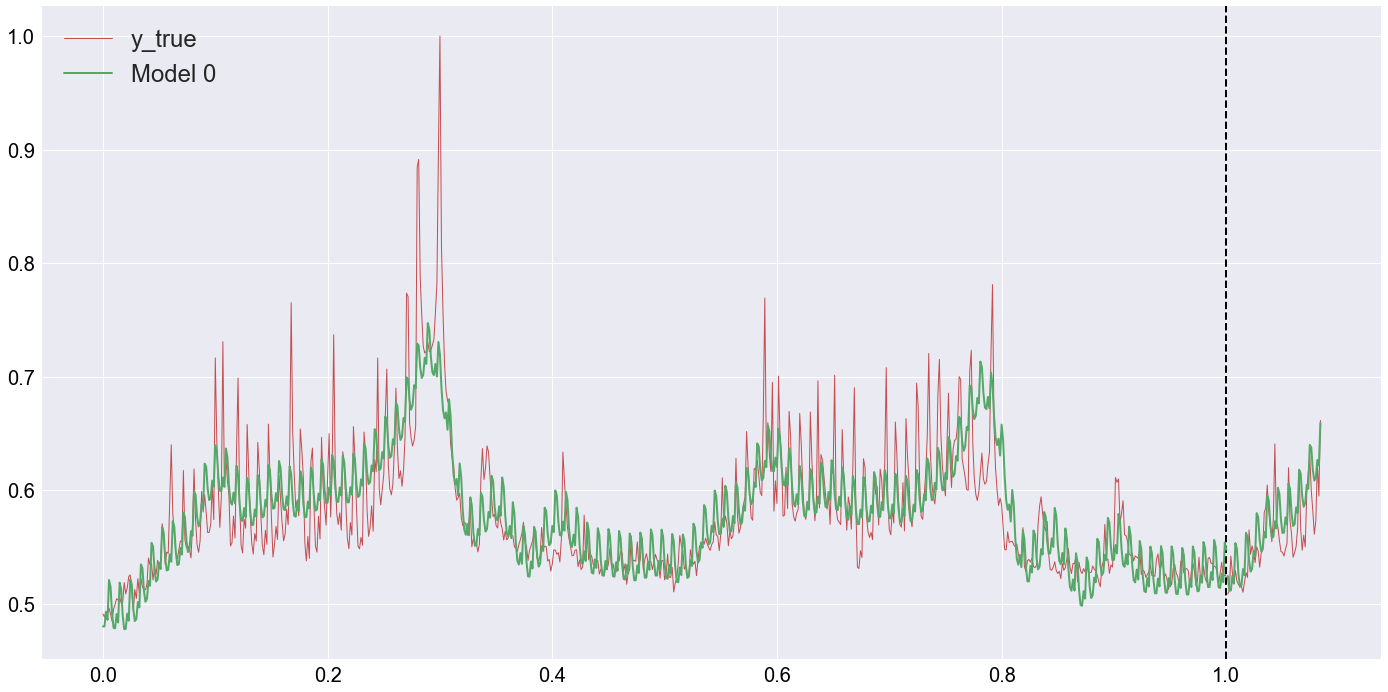

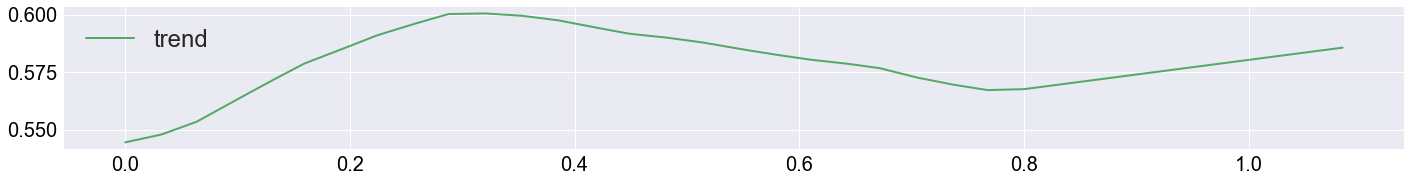

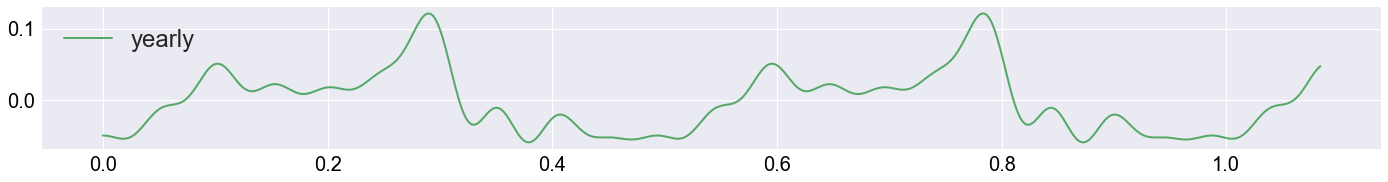

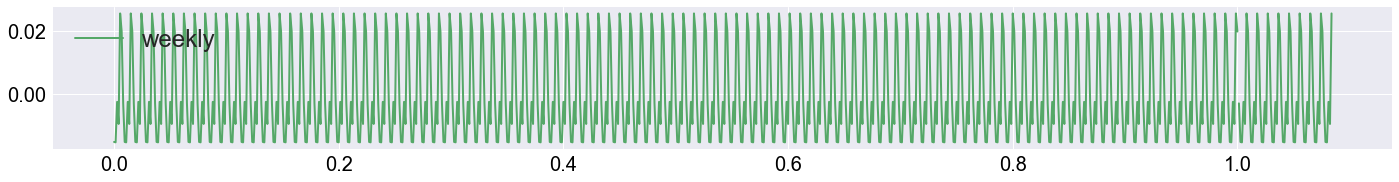

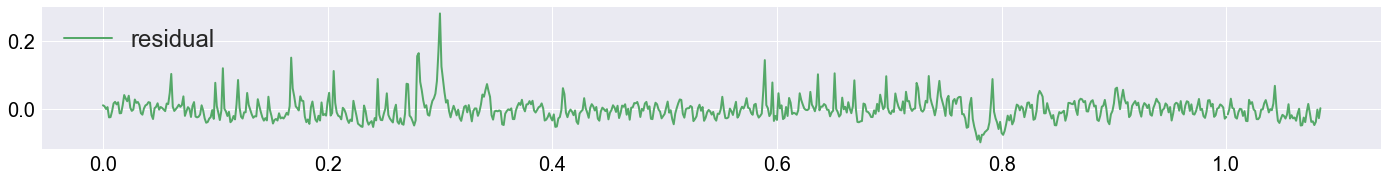

In [13]:
result_example = {"predictions": [pred_example], 
                  "metrics": [metrics_example]}
result_train_example = {"predictions": [pred_train_example]}
visualize_results([result_example], [result_train_example], ts_data, ts_idx=0)

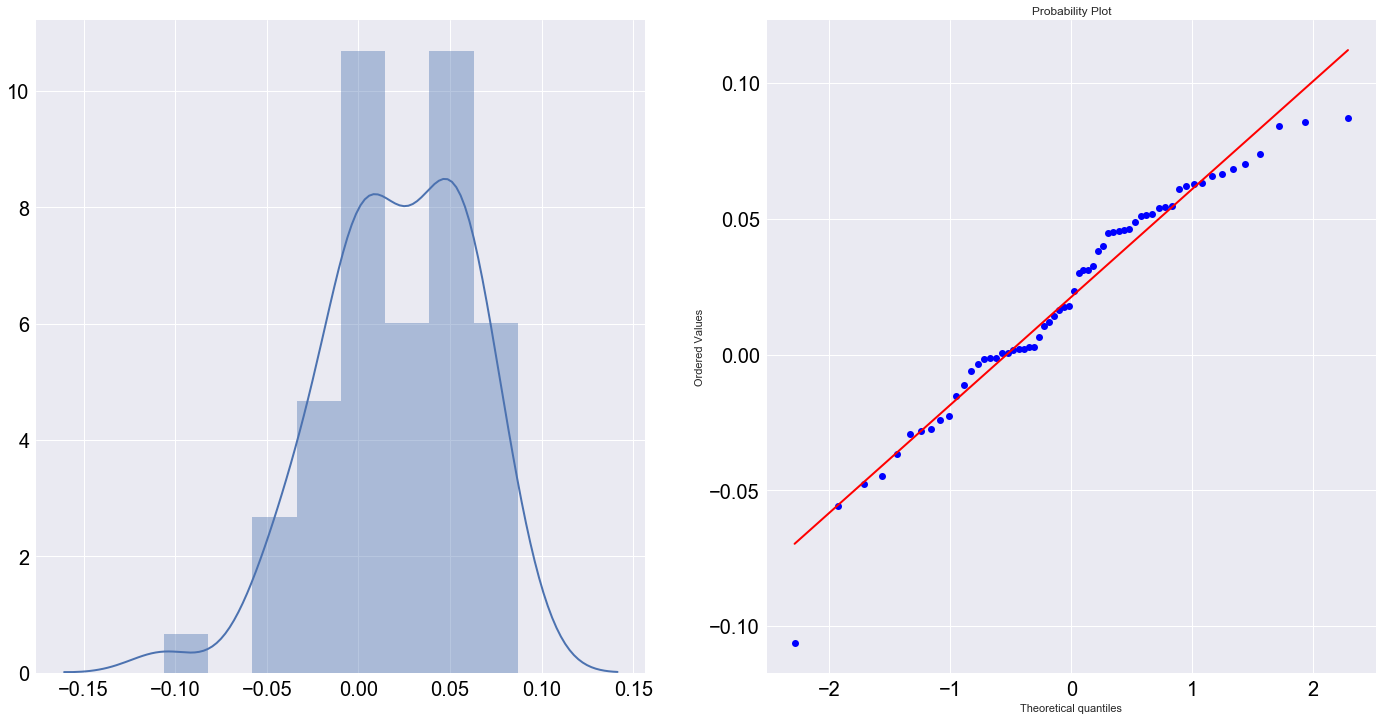

In [14]:
# Percentage Residual Check 
import scipy.stats as stats

plt.subplot(121)
resids = (pred_example["y"].as_matrix() - ts_example["future"]["y_scaled"].as_matrix()) / ts_example["future"]["y_scaled"].as_matrix()
sns.distplot(resids)
plt.subplot(122)
stats.probplot(resids, dist="norm", plot=plt)
plt.show()

#### Posterior Predictive Check 

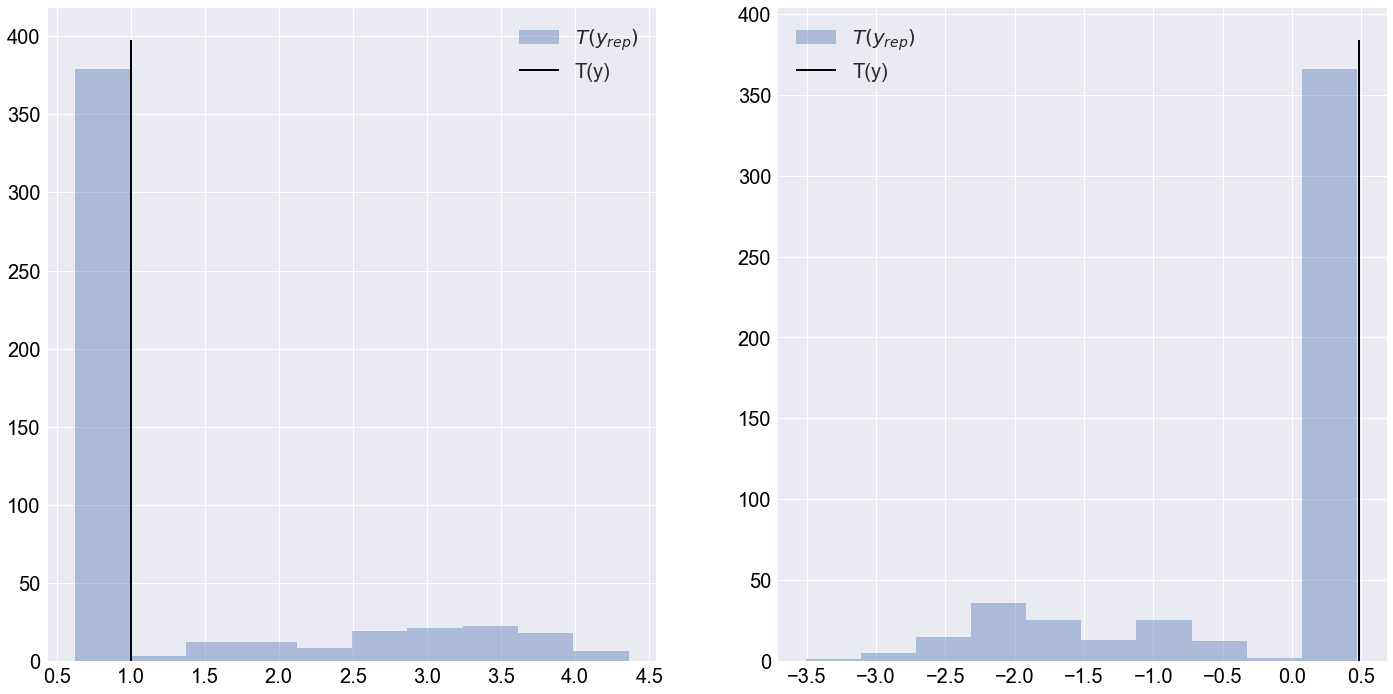

In [15]:
y_post = ed.copy(y, posts_dict)
ty_rep, ty = ed.ppc(lambda xs, zs: tf.reduce_max(tf.cast(xs[y_post], tf.float32)), 
       data={y_post:ts_data[0]["history"]["y_scaled"].as_matrix(), 
            t: train_data['t'],
            A: train_data['A'], 
            X: train_data['X'].as_matrix(), 
            sigmas: train_data['sigmas'], 
            t_change: train_data["t_change"]},n_samples=500)    
plt.subplot(121)
ed.ppc_stat_hist_plot(
    ty[0], ty_rep, stat_name=r'$T \equiv$max', bins=10)
plt.legend(fontsize=20)
plt.subplot(122)
ty_rep, ty = ed.ppc(lambda xs, zs: tf.reduce_min(tf.cast(xs[y_post], tf.float32)), 
       data={y_post:ts_data[0]["history"]["y_scaled"].as_matrix(), 
            t: train_data['t'],
            A: train_data['A'], 
            X: train_data['X'].as_matrix(), 
            sigmas: train_data['sigmas'], 
            t_change: train_data["t_change"]},n_samples=500)    
ed.ppc_stat_hist_plot(
    ty[0], ty_rep, stat_name=r'$T \equiv$min', bins=10)
plt.legend(fontsize=20)
plt.show()

## Round 1: 
___
The above results confirm that our basic model captures the web traffic time series generally well. We start to research the problem raised at the begining: **Will inferring several time series of related content together further improve the model's forecasting results?**

In Round 0, we saw regions of "overfitting" in one or two cases, where the trend component is overly influenced by outliers. In order to reduce the overfitting effect and to increase the average forecasting accuracy, we came up with the idea of connecting several related time series together with hierarchical priors. 


### Mixed Models with Hieraricial Priors

We extend the basic model to infer a group of time series together by adding global hierarical priors to two latent variables $k$ (the linear slope), and $\beta$ (the smoothers of seasonality).

We implemented and compared the following three models:
* **Model1**  is the same as our basic model. Each time series has its own set of local latent variables $k$, $m$, $\sigma_obs$, $\beta$, and $\delta$.

* **Model3** inherits **Model1** and adds a global prior $gbeta$.
   $$ beta_i \sim Normal(gbeta, \sigma_{beta_i})\;\;\;  (i=1,...,N\_TS)$$
   $$ gbeta \sim Normal(0, \sigma_{gbeta})$$


* **Model4** inherits **Model1** and adds a global prior $gk$.  
  $$k_i \sim Normal(gk, \; \sigma_{k_i})\;\;\; (i=1,...,N\_TS)$$
  $$gk \sim Normal(0, \sigma_{gk})$$
 
    
We build a pipeline to train each model on our timeseries of 10 NFL-related Wikipages and compare their prediction accuarcies.

In [16]:
#%%capture
results = []
models_test = [Model1(), Model3(), Model4()]
print("Fitting %d Timeseries" % len(ts_data))
for model in models_test:
    p, m = pipeline(ts_data, model, train_data, test_data, 
                    ITR=5000, N_STEPS=2, STEP_SIZE=5e-4)
    results.append({"predictions": p, "metrics": m})

Fitting 10 Timeseries
[+] Building model
[+] Running inference
5000/5000 [100%] ██████████████████████████████ Elapsed: 67s | Acceptance Rate: 0.587
[+] Making prediction
[+] Building model
[+] Running inference
5000/5000 [100%] ██████████████████████████████ Elapsed: 74s | Acceptance Rate: 0.787
[+] Making prediction
[+] Building model
[+] Running inference
5000/5000 [100%] ██████████████████████████████ Elapsed: 88s | Acceptance Rate: 0.711
[+] Making prediction


In [17]:
total_metrics = []
for j, r in enumerate(results):
    m_pd = pd.DataFrame.from_dict(r["metrics"])
    m_pd.loc['mean'] = m_pd.mean()
    total_metrics.append(m_pd)
pd.concat(total_metrics, axis=1)

,model1-MAPE,model1-MSE,model1-SMAPE,model3-MAPE,model3-MSE,model3-SMAPE,model4-MAPE,model4-MSE,model4-SMAPE
0,3.387806,0.000553,3.383256,3.571079,0.000723,3.673537,3.533526,0.000713,3.634297
1,5.116845,0.001635,4.975179,5.216001,0.001647,5.059343,4.433259,0.001310,4.320388
2,6.839928,0.002115,7.182721,4.622114,0.001138,4.757186,4.609524,0.001061,4.695918
3,4.156450,0.001376,4.102259,4.216710,0.001500,4.192338,3.994424,0.001414,4.013432
4,4.787992,0.001819,4.751508,8.122059,0.004771,8.617298,6.486333,0.002920,6.702587
5,3.509429,0.000956,3.503438,3.174826,0.000920,3.257507,3.298267,0.000968,3.385439
6,5.069978,0.001283,4.920467,4.907926,0.001162,4.783815,5.227197,0.001281,5.084892
7,5.048415,0.001594,4.877200,3.279332,0.000702,3.218096,4.394100,0.001193,4.265402
8,9.596088,0.002926,9.084949,5.474949,0.001045,5.293842,5.133907,0.000934,4.973543
9,4.306163,0.001185,4.290891,3.837771,0.001010,3.815492,4.909114,0.001411,4.799740


We plot the percentage residual distribution for each data and compare `Model1`, `Model3` and `Model4` from left to right. As shown, the spreads become narrower towards the center and most of residuals are centered at 0. 

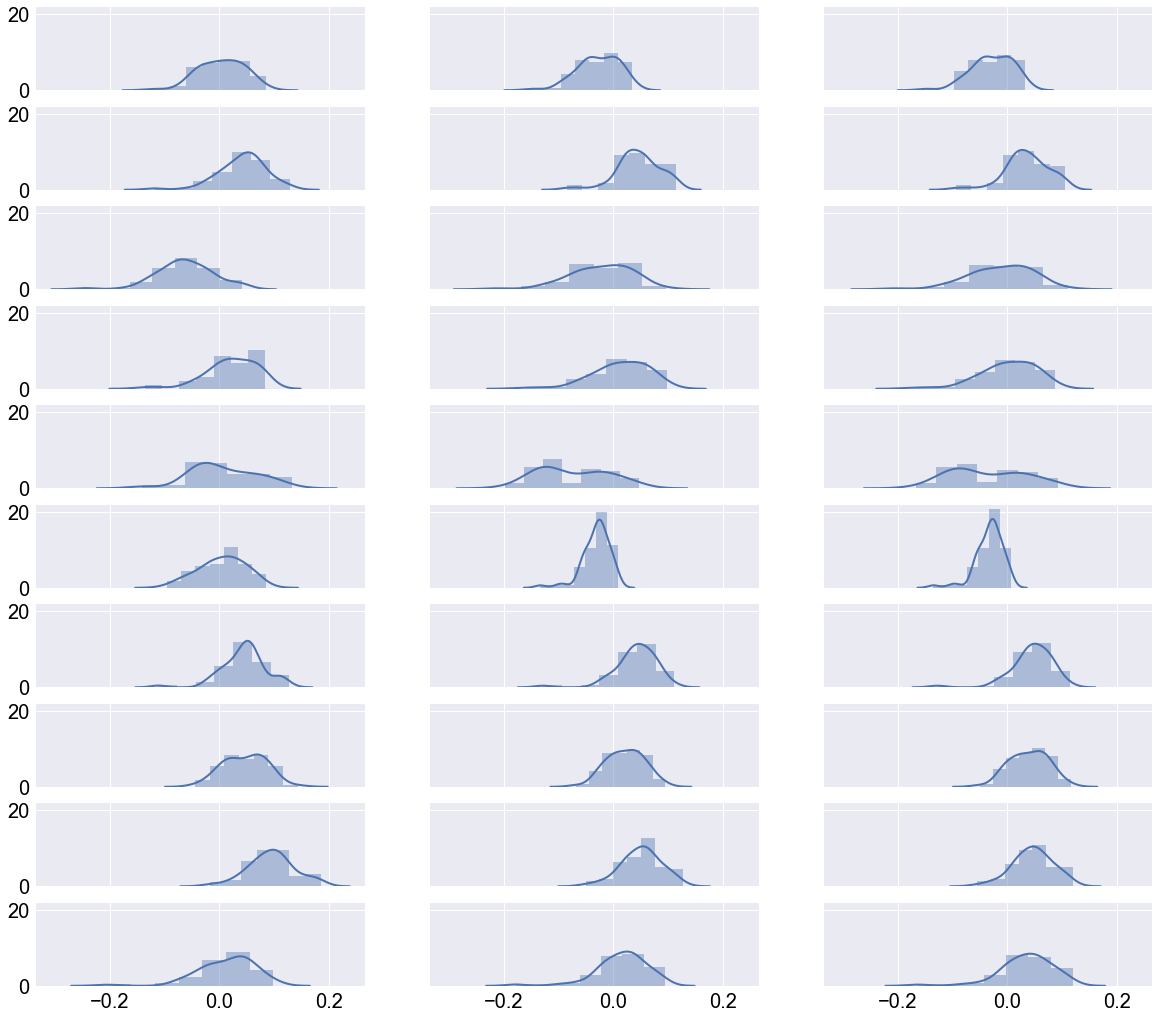

In [24]:
# residual
fig, axes = plt.subplots(len(ts_data), len(results), figsize=(20,18),
                         sharex=True, sharey=True)      
for j, r in enumerate(results):
    for i, ts in enumerate(ts_data):
        resids = (r["predictions"][i]["y"].as_matrix() - ts["future"]["y_scaled"].as_matrix()) \
                 / ts["future"]["y_scaled"].as_matrix()
        sns.distplot(resids, ax = axes[i, j],bins=7)
plt.show()

In [19]:
# Fit Training 
results_train = []
for model in models_test:
    predictions = []
    metrics = []
    for i, ts in enumerate(ts_data):
        df = pd.DataFrame({"ds": ts["history"]["ds"].copy(),
                           "t": ts["history"]["t"].copy()})
        df.reset_index(inplace=True, drop=True)
        df = predict_fixed(df, model.post_params[i], train_data)
        predictions.append(df)
        y_true = ts["history"]["y_scaled"].as_matrix()
        metrics.append(evaluate(y_true, df["y"]))
            
    results_train.append({
        "predictions": predictions, 
        "metrics": metrics,
    })

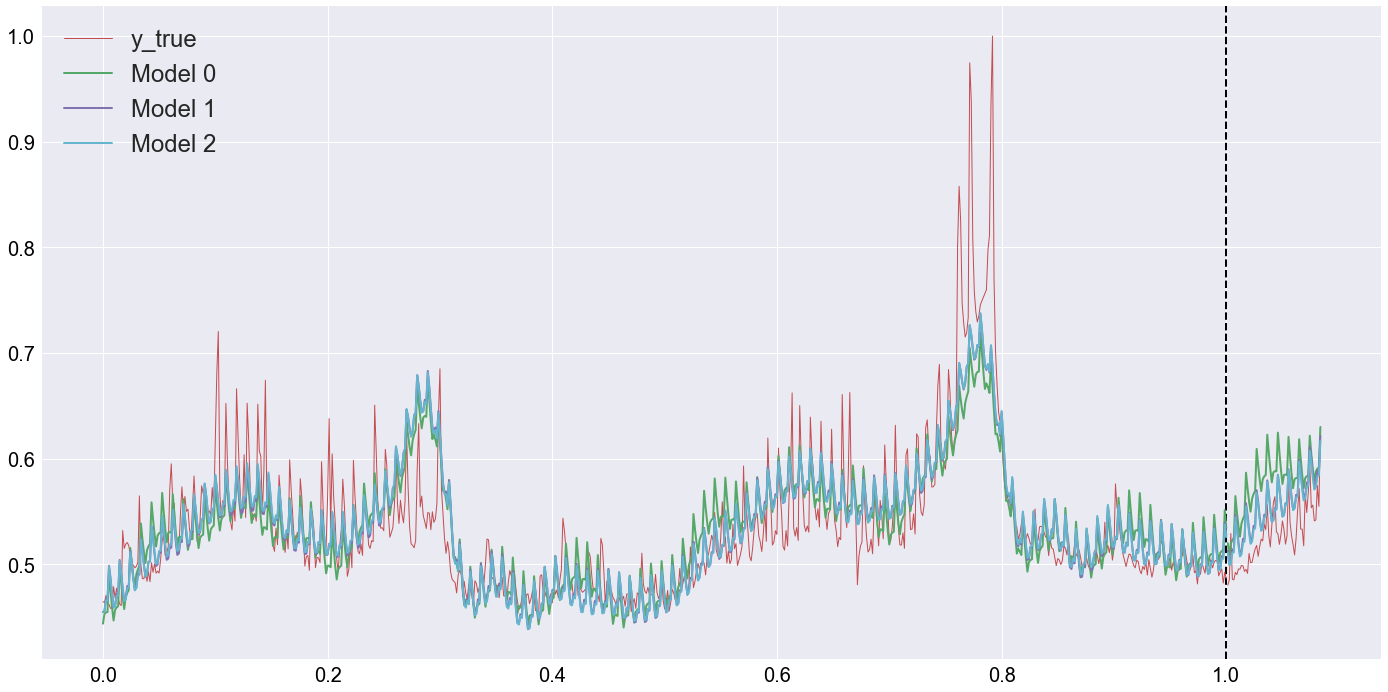

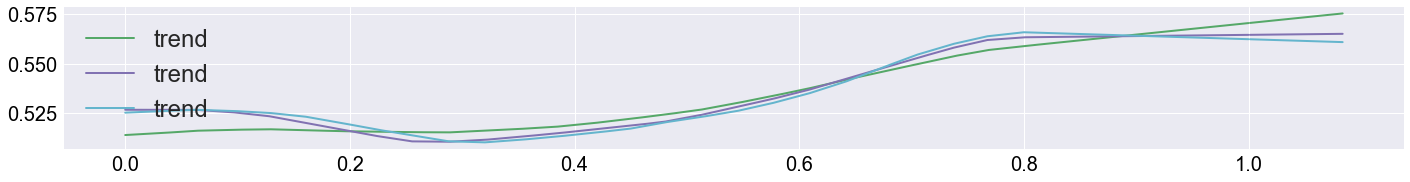

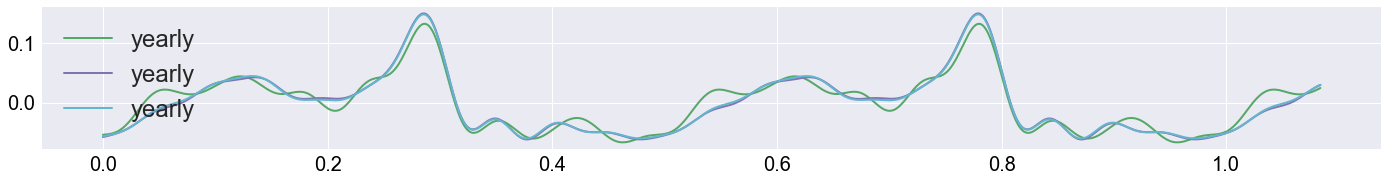

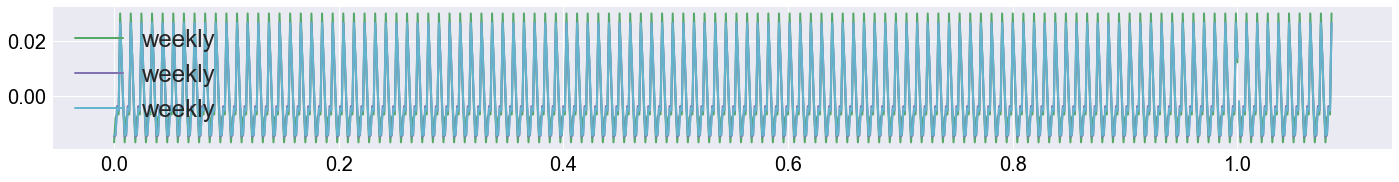

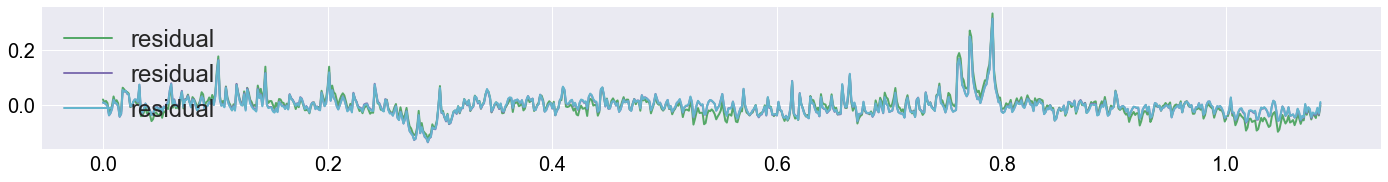

In [27]:
visualize_results(results, results_train, ts_data, ts_idx=8)

###  Criticism -- Global Prior $gbeta$

**Model3** inherits **Model1** and adds a global prior $gbeta$.
   $$ beta_i \sim Normal(gbeta, \sigma_{beta_i})\;\;\;  (i=1,...,N\_TS)$$
   $$ gbeta \sim Normal(0, \sigma_{gbeta})$$


We expect that the time series group share the same seasonality patterns, i.e, similiar seasonality smoothers. Therefore we implement Model3 with a global prior $gbeta$ controlling the mean of the local seasonality priors $beta$. 

The plots below show the posterior means of local priors $beta$ for Model1 and Model3. 0-19 on the horizontal axis are  smoothers for yearly seasonality and 20-25 for weekly seasonality. We observe that the posterior mean distributions of the time series are more clustered in `Model3` plot.



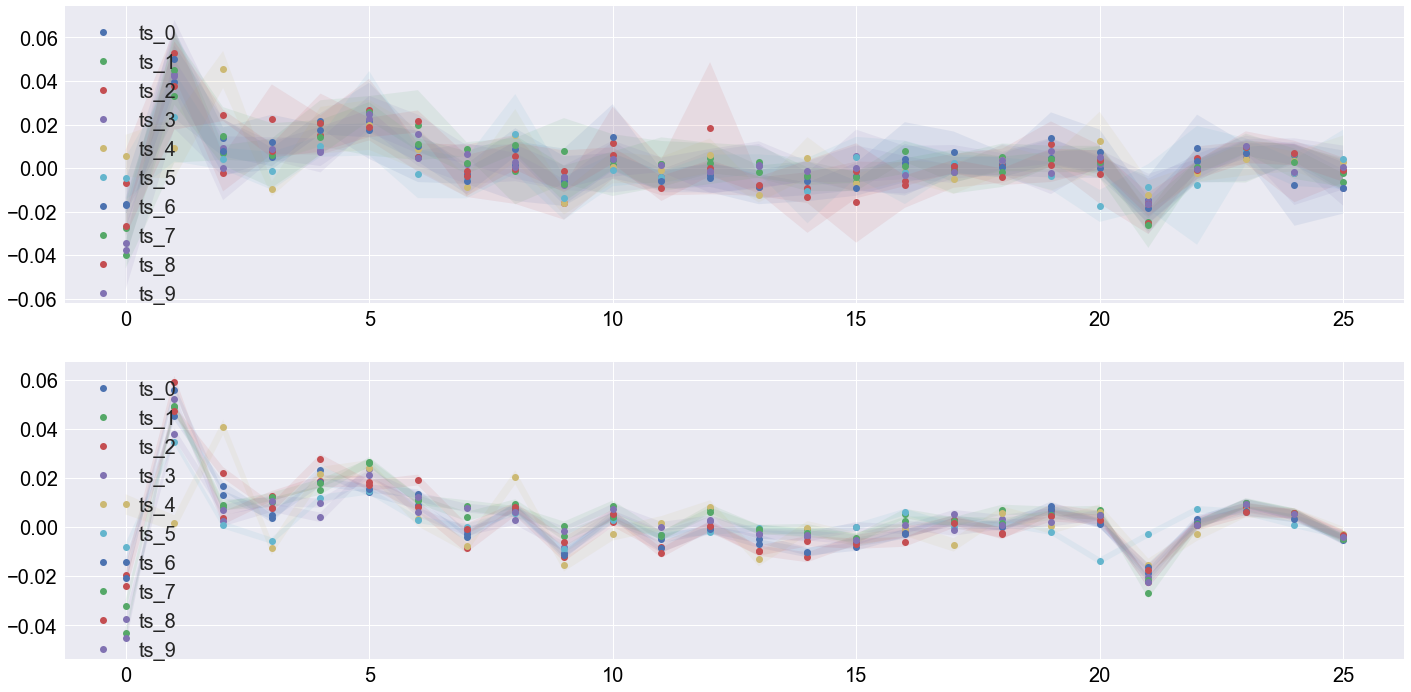

In [34]:
for m, model in enumerate([models_test[0], models_test[1]]):
    plt.subplot(2, 1, m+1)
    nbeta = len(model.post_params[i]["beta"][0])
    for i, ts in enumerate(ts_data):
        beta_mean = np.mean(model.post_params[i]["beta"], axis=0)
        beta_std = np.std(model.post_params[i]["beta"], axis=0)
        plt.plot(beta_mean, 'o', label='ts_'+str(i))
        plt.fill_between(range(nbeta), beta_mean -  beta_std,
                         beta_mean + beta_std, alpha=.1)        
    plt.legend(loc=2, fontsize=20)
plt.show()

### Criticism -- Global Prior $gk$

**Model4** inherits **Model1** and adds a global prior $gk$.  
  $$k_i \sim Normal(gk, \; \sigma_{k_i})\;\;\; (i=1,...,N\_TS)$$
  $$gk \sim Normal(0, \sigma_{gk})$$

In the below plots, we visualize posterior distribution of local $k$ for all timeseries. By adding a global prior to  local trend parameter $k$, the posterior means of $k$ of the time series become normally distributed with mean at 0.



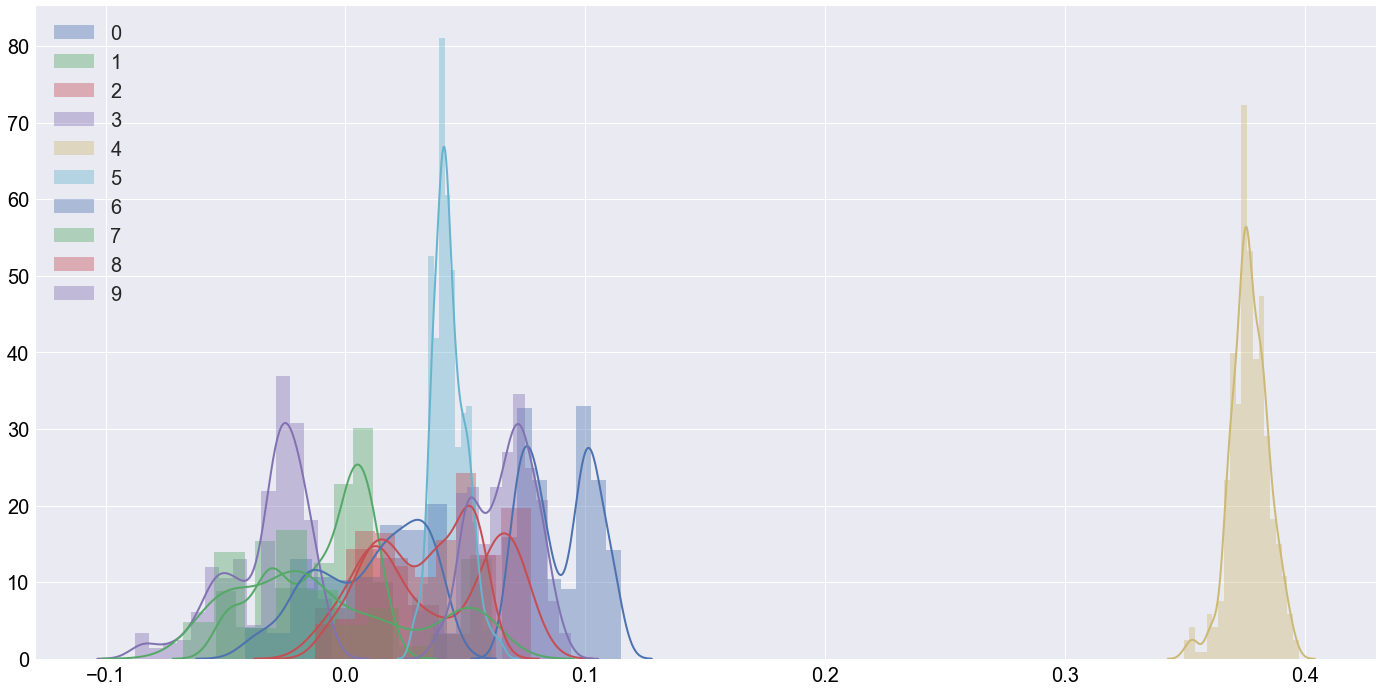

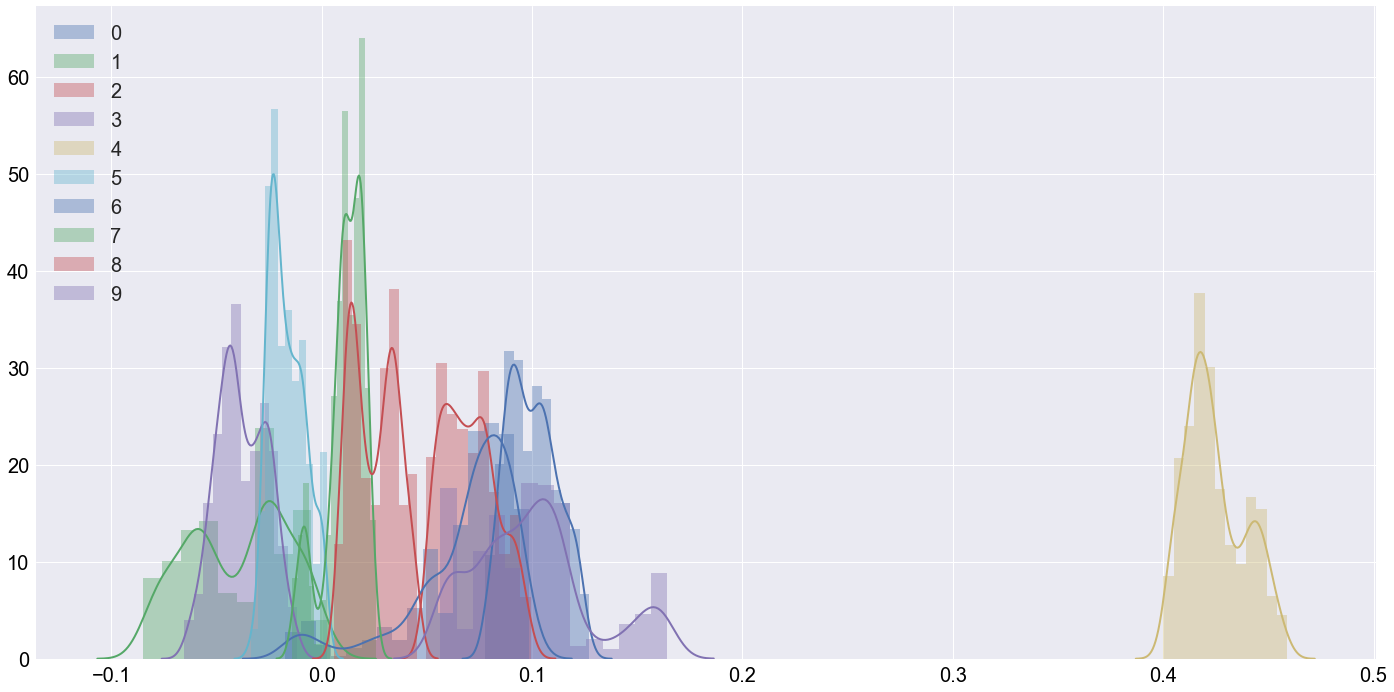

In [36]:
# Model 1
for m, model in enumerate([models_test[0], models_test[2]]):
    #print(model.name)
    for i, ts in enumerate(ts_data):
        sns.distplot(model.post_params[i]["k"], label=str(i))
        #print("TS %d: %f, %f" % (i, np.mean(model.post_params[i]["k"]), 
        #                         np.std(model.post_params[i]["k"])))
    plt.legend(loc=2, fontsize=20)
    plt.show()

## More Discussion

### Outlier
In the graph above, we encounter an interesting outlier in color yellow. The corresponding time series represents web traffic for the [Los Angels Rams wiki](https://en.wikipedia.org/wiki/Los_Angeles_Rams#Los_Angeles_Rams_.282016.E2.80.93present.29). As we traced back, the Rams was based in St.Louis from 1995-2015 and just moved back to Los Aneles in 2016 and this transition period is included in the training data. As a result, its page visits rapidly grow since then and has a larger slope $k$ compared to the rest of time series.

### Parameter Tuning
- Ways to initialize linear growth slope $k$ and intercept $m$
   - global slope and intercept 
   - local slope and intercept (last P days)
  
  
* Effects of Holiday Features
   * US public holiday vs page-related events
   * domain knowledge
 
 
* Changepoint regularization ($\tau$) 
   * Fixed value vs latent variable 
  
### Experience with Edward
* Fast inference  
* Iteration through Box's loop 

